<center>
<h1><b>Lab 3</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>September 17, 2020</b></h3>
</center>

### Imports

In [1]:
import numpy as np
import sympy as sp
from scipy.special import ellipk
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from functools import partial

### Support Functions

In [2]:
def euler_step(f, y, t, dt):
    y = y + f(t, y) * dt
    return y


def rk2_step(f, y, t, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + dt, y + k1)
    y = y + (k1 + k2) / 2.0
    return y


def euler_cromer_step(f, y, dy, t, dt):
    dy = dy + f(t, y, dy) * dt
    y = y + dy * dt
    return y, dy


def dsolve(f, t, y0, step = euler_step):
    t = np.asarray(t)  # Ensure t is a Numpy array
    y0 = np.asarray(y0)

    y = np.zeros((np.size(t), np.size(y0)))  # Create our output data container
    y[0] = y0  # Set initial condition

    for i in range(np.size(t)-1):
        y[i+1] = step(f, y[i], t[i], t[i+1] - t[i])  # Step forward
    return t, np.hsplit(y, np.size(y0))


def dsolve_simplectic(f, t, y0, dy0, step = euler_cromer_step):
    t = np.asarray(t)  # Ensure t is a Numpy array
    y0 = np.asarray(y0)

    y = np.zeros((np.size(t), np.size(y0)))  # Create our output data container
    dy = np.zeros((np.size(t), np.size(dy0)))  # Create our output data container
    y[0] = y0  # Set initial condition
    dy[0] = dy0  # Set initial condition

    for i in range(np.size(t)-1):
        y[i+1], dy[i+1] = step(f, y[i], dy[i], t[i], t[i+1] - t[i])  # Step forward

    return t, y, dy


def get_kinetic_energy(I, omega):
    return 0.5 * I * omega ** 2


def get_potential_energy(m, g, l, theta):
    return m * g * l * (1.0 - np.cos(theta))


def get_total_energy(m, I, l, g, theta, omega):
    return get_kinetic_energy(I, omega) + get_potential_energy(m, g, l, theta)


def global_error(exact, calculated):
    error = np.zeros_like(exact)
    for i in range(len(error)):
        error[i] = calculated[i] - exact[i]
    return error


def local_error(y_exact, y_approx, x):
    error = np.zeros_like(x)
    for i in np.arange(1, len(error)):
        error[i-1] = y_exact[i] - y_exact[i-1] - (y_approx[i] - y_approx[i-1])
    return error

### Analytical Calculations

$$I\ddot{\theta}+c\dot{\theta}+mgl\theta=F_0\cos(\omega_Dt)\rightarrow\ddot{\theta}+\frac{c}{I}\dot{\theta}+\frac{mgl}{I}\theta=\frac{F_0}{I}\cos(\omega_Dt)$$
Using:
$$A=\frac{F_0}{I},\quad\beta=\frac{c}{2\sqrt{mglI}},\quad\omega_0=\sqrt{\frac{mgl}{I}}$$
Gives:
$$\ddot{\theta}+2\beta\omega_0\dot{\theta}+\omega_0^2\theta=A\cos(\omega_Dt)$$


In [3]:
def df_linear_pendula(t, x, zeta, w0, A, wd):
    return np.asarray([x[1], -2 * zeta * w0 * x[1] - w0 ** 2 * x[0] + A * np.cos(wd * t)])

def df_linear_pendula_simplectic(t, x, dx, zeta, w0, A, wd):
    return -2 * zeta * w0 * dx - w0 ** 2 * x + A * np.cos(wd * t)

# Number 1

## Analytical Solution

In [4]:
omega_0, t, theta0, dtheta0 = sp.symbols(r'\omega_0 t \theta_0 \dot{\theta}_0')
theta = sp.Function(r'\theta')

ode = sp.Eq(sp.Derivative(theta(t), t, t) + omega_0**2*theta(t),0)
ics = {theta(0): theta0, theta(t).diff(t).subs(t, 0): dtheta0}
soln = sp.dsolve(ode, theta(t), ics=ics).rewrite(sp.cos).simplify()
theta_func = soln.rhs
omega_func = theta_func.diff(t)

m, g, l, I = sp.symbols(r'm g l I')

V = m * g * l * (1 - sp.cos(theta_func))
T = I * omega_func ** 2 / 2
H = V + T

In [5]:
theta_func

\dot{\theta}_0*sin(\omega_0*t)/\omega_0 + \theta_0*cos(\omega_0*t)

In [6]:
H

I*(\dot{\theta}_0*cos(\omega_0*t) - \omega_0*\theta_0*sin(\omega_0*t))**2/2 + g*l*m*(1 - cos(\dot{\theta}_0*sin(\omega_0*t)/\omega_0 + \theta_0*cos(\omega_0*t)))

In [7]:
def theta_exact(t, theta0, dtheta0, w0):
    t = np.asarray(t)       
    return dtheta0 * np.sin(w0 * t) / w0 + theta0 * np.cos(w0 * t)

def total_energy_exact(t, theta0, dtheta0, w0, m, g, l, I):
    t = np.asarray(t)
    return I * (dtheta0 * np.cos(w0 * t) - w0 * theta0 * np.sin(w0 * t))**2 / 2 + m*g*l*(1-np.cos(dtheta0 * np.sin(w0 * t) / w0 + theta0 * np.cos(w0 * t)))

## Parameters

In [8]:
m = 1.0
g = 9.81
l = 1.0
I = m*l**2
c = 0.0
F0 = 0.0

A = F0/I
zeta = c/(2*np.sqrt(m*g*l*I))  # Damping ratio
w0 = np.sqrt(m*g*l/I)
wd = 1.0

theta0 = np.pi/2.0
dtheta0 = 0.0

ti = 0
tf = 10
dt = 0.001
t = np.arange(ti, tf, dt)
state0 = np.asarray([theta0, dtheta0])

## Calculate Trajectories

In [9]:
## Curried differential equation
df = partial(df_linear_pendula, zeta=zeta, w0=w0, A=A, wd=wd)
df_simplectic = partial(df_linear_pendula_simplectic, zeta=zeta, w0=w0, A=A, wd=wd)

## Solutions
t, pendula_euler = dsolve(df, t, state0, step=euler_step)
t, pendula_rk2 = dsolve(df, t, state0, step=rk2_step)
t, *pendula_euler_cromer = dsolve_simplectic(df_simplectic, t, theta0, dtheta0)

## Energies
pendula_euler_energy = get_total_energy(m, I, l, g, *pendula_euler)
pendula_rk2_energy = get_total_energy(m, I, l, g, *pendula_rk2)
pendula_euler_cromer_energy = get_total_energy(m, I, l, g, *pendula_euler_cromer)

theta_analytic = theta_exact(t, theta0, dtheta0, w0)
total_energy_analytic = total_energy_exact(t, theta0, dtheta0, w0, m, g, l, I)

## Plotting

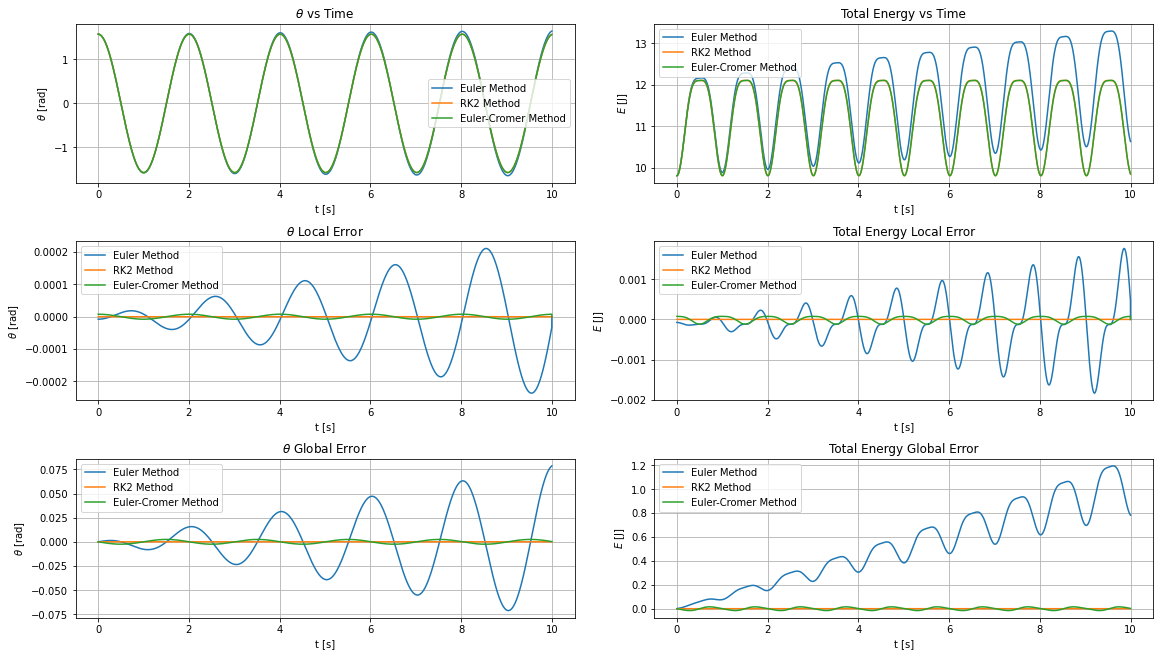

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(16, 9), constrained_layout=True)

ax[0,0].plot(t, pendula_euler[0], label='Euler Method')
ax[0,0].plot(t, pendula_rk2[0], label='RK2 Method')
ax[0,0].plot(t, pendula_euler_cromer[0], label='Euler-Cromer Method')
ax[0,0].set_xlabel(r't [s]')
ax[0,0].set_ylabel(r'$\theta$ [rad]')
ax[0,0].set_title(r'$\theta$ vs Time')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(t, pendula_euler_energy, label='Euler Method')
ax[0,1].plot(t, pendula_rk2_energy,label='RK2 Method')
ax[0,1].plot(t, pendula_euler_cromer_energy, label='Euler-Cromer Method')
ax[0,1].set_xlabel(r't [s]')
ax[0,1].set_ylabel(r'$E$ [J]')
ax[0,1].set_title('Total Energy vs Time')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(t, local_error(theta_analytic, pendula_euler[0], t), label='Euler Method')
ax[1,0].plot(t, local_error(theta_analytic, pendula_rk2[0], t), label='RK2 Method')
ax[1,0].plot(t, local_error(theta_analytic, pendula_euler_cromer[0], t), label='Euler-Cromer Method')
ax[1,0].set_xlabel(r't [s]')
ax[1,0].set_ylabel(r'$\theta$ [rad]')
ax[1,0].set_title(r'$\theta$ Local Error')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(t, local_error(total_energy_analytic, pendula_euler_energy, t), label='Euler Method')
ax[1,1].plot(t, local_error(total_energy_analytic, pendula_rk2_energy, t),label='RK2 Method')
ax[1,1].plot(t, local_error(total_energy_analytic, pendula_euler_cromer_energy, t), label='Euler-Cromer Method')
ax[1,1].set_xlabel(r't [s]')
ax[1,1].set_ylabel(r'$E$ [J]')
ax[1,1].set_title('Total Energy Local Error')
ax[1,1].grid()
ax[1,1].legend()

ax[2,0].plot(t, global_error(theta_analytic, pendula_euler[0]), label='Euler Method')
ax[2,0].plot(t, global_error(theta_analytic, pendula_rk2[0]), label='RK2 Method')
ax[2,0].plot(t, global_error(theta_analytic, pendula_euler_cromer[0]), label='Euler-Cromer Method')
ax[2,0].set_xlabel(r't [s]')
ax[2,0].set_ylabel(r'$\theta$ [rad]')
ax[2,0].set_title(r'$\theta$ Global Error')
ax[2,0].grid()
ax[2,0].legend()

ax[2,1].plot(t, global_error(total_energy_analytic, pendula_euler_energy), label='Euler Method')
ax[2,1].plot(t, global_error(total_energy_analytic, pendula_rk2_energy),label='RK2 Method')
ax[2,1].plot(t, global_error(total_energy_analytic, pendula_euler_cromer_energy), label='Euler-Cromer Method')
ax[2,1].set_xlabel(r't [s]')
ax[2,1].set_ylabel(r'$E$ [J]')
ax[2,1].set_title('Total Energy Global Error')
ax[2,1].grid()
ax[2,1].legend()

plt.show()

## Repeat With Different Initial Conditions

In [11]:
theta0 = 0.0
dtheta0 = np.pi/2.0

state0 = np.asarray([theta0, dtheta0])

In [12]:
## Curried differential equation
df = partial(df_linear_pendula, zeta=zeta, w0=w0, A=A, wd=wd)
df_simplectic = partial(df_linear_pendula_simplectic, zeta=zeta, w0=w0, A=A, wd=wd)

## Solutions
t, pendula_euler = dsolve(df, t, state0, step=euler_step)
t, pendula_rk2 = dsolve(df, t, state0, step=rk2_step)
t, *pendula_euler_cromer = dsolve_simplectic(df_simplectic, t, theta0, dtheta0)

## Energies
pendula_euler_energy = get_total_energy(m, I, l, g, *pendula_euler)
pendula_rk2_energy = get_total_energy(m, I, l, g, *pendula_rk2)
pendula_euler_cromer_energy = get_total_energy(m, I, l, g, *pendula_euler_cromer)

theta_analytic = theta_exact(t, theta0, dtheta0, w0)
total_energy_analytic = total_energy_exact(t, theta0, dtheta0, w0, m, g, l, I)

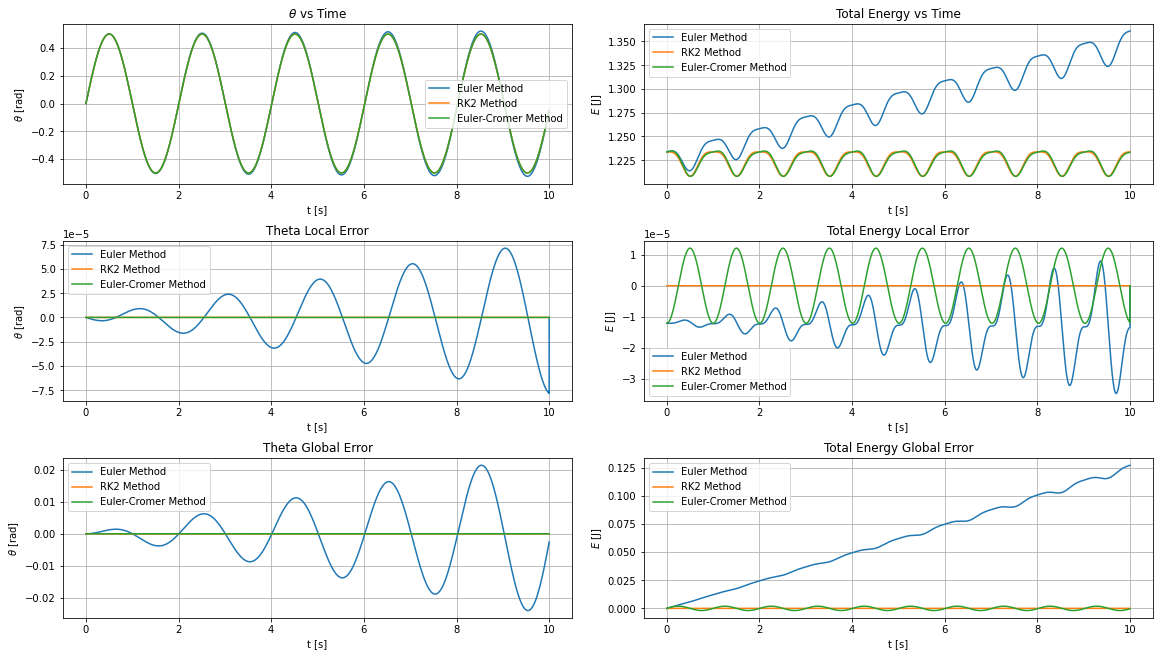

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(16, 9), constrained_layout=True)

ax[0,0].plot(t, pendula_euler[0], label='Euler Method')
ax[0,0].plot(t, pendula_rk2[0], label='RK2 Method')
ax[0,0].plot(t, pendula_euler_cromer[0], label='Euler-Cromer Method')
ax[0,0].set_xlabel(r't [s]')
ax[0,0].set_ylabel(r'$\theta$ [rad]')
ax[0,0].set_title(r'$\theta$ vs Time')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(t, pendula_euler_energy, label='Euler Method')
ax[0,1].plot(t, pendula_rk2_energy,label='RK2 Method')
ax[0,1].plot(t, pendula_euler_cromer_energy, label='Euler-Cromer Method')
ax[0,1].set_xlabel(r't [s]')
ax[0,1].set_ylabel(r'$E$ [J]')
ax[0,1].set_title('Total Energy vs Time')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(t, local_error(theta_analytic, pendula_euler[0], t), label='Euler Method')
ax[1,0].plot(t, local_error(theta_analytic, pendula_rk2[0], t), label='RK2 Method')
ax[1,0].plot(t, local_error(theta_analytic, pendula_euler_cromer[0], t), label='Euler-Cromer Method')
ax[1,0].set_xlabel(r't [s]')
ax[1,0].set_ylabel(r'$\theta$ [rad]')
ax[1,0].set_title('Theta Local Error')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(t, local_error(total_energy_analytic, pendula_euler_energy, t), label='Euler Method')
ax[1,1].plot(t, local_error(total_energy_analytic, pendula_rk2_energy, t),label='RK2 Method')
ax[1,1].plot(t, local_error(total_energy_analytic, pendula_euler_cromer_energy, t), label='Euler-Cromer Method')
ax[1,1].set_xlabel(r't [s]')
ax[1,1].set_ylabel(r'$E$ [J]')
ax[1,1].set_title('Total Energy Local Error')
ax[1,1].grid()
ax[1,1].legend()

ax[2,0].plot(t, global_error(theta_analytic, pendula_euler[0]), label='Euler Method')
ax[2,0].plot(t, global_error(theta_analytic, pendula_rk2[0]), label='RK2 Method')
ax[2,0].plot(t, global_error(theta_analytic, pendula_euler_cromer[0]), label='Euler-Cromer Method')
ax[2,0].set_xlabel(r't [s]')
ax[2,0].set_ylabel(r'$\theta$ [rad]')
ax[2,0].set_title('Theta Global Error')
ax[2,0].grid()
ax[2,0].legend()

ax[2,1].plot(t, global_error(total_energy_analytic, pendula_euler_energy), label='Euler Method')
ax[2,1].plot(t, global_error(total_energy_analytic, pendula_rk2_energy),label='RK2 Method')
ax[2,1].plot(t, global_error(total_energy_analytic, pendula_euler_cromer_energy), label='Euler-Cromer Method')
ax[2,1].set_xlabel(r't [s]')
ax[2,1].set_ylabel(r'$E$ [J]')
ax[2,1].set_title('Total Energy Global Error')
ax[2,1].grid()
ax[2,1].legend()

plt.show()

# Number 2

## Parameters

In [14]:
m = 1.0
g = 9.81
l = 1.0
I = m*l**2
c1 = 2*np.sqrt(m*g*l*I) / 10
c2 = 2*np.sqrt(m*g*l*I)
c3 = 2*np.sqrt(m*g*l*I) * 10
F0 = 1.0

A = F0/I
zeta1 = c1/(2*np.sqrt(m*g*l*I))  # Damping ratio
zeta2 = c2/(2*np.sqrt(m*g*l*I))  # Damping ratio
zeta3 = c3/(2*np.sqrt(m*g*l*I))  # Damping ratio
w0 = np.sqrt(m*g*l/I)
wd = 1.0

ti = 0
tf = 50
dt = 0.001
t = np.arange(ti, tf, dt)

state0 = np.asarray([-np.pi / 2.0, np.pi / 2.0])

## Calculate Trajectories

In [15]:
## Curried differential equation
df1_simplectic = partial(df_linear_pendula_simplectic, zeta=zeta1, w0=w0, A=A, wd=wd)
df2_simplectic = partial(df_linear_pendula_simplectic, zeta=zeta2, w0=w0, A=A, wd=wd)
df3_simplectic = partial(df_linear_pendula_simplectic, zeta=zeta3, w0=w0, A=A, wd=wd)

## Solutions
t, *pendula_euler_cromer_1 = dsolve_simplectic(df1_simplectic, t, state0[0], state0[1])
t, *pendula_euler_cromer_2 = dsolve_simplectic(df2_simplectic, t, state0[0], state0[1])
t, *pendula_euler_cromer_3 = dsolve_simplectic(df3_simplectic, t, state0[0], state0[1])

## Plotting

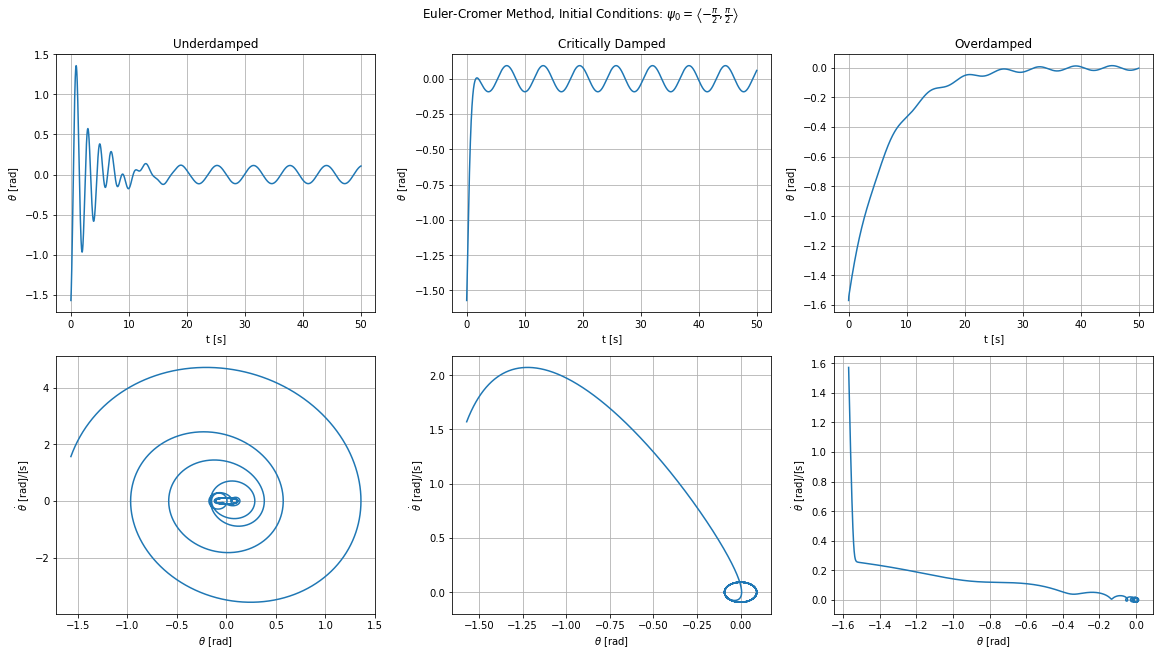

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)
plt.suptitle(r'Euler-Cromer Method, Initial Conditions: $\psi_0=\left<-\frac{\pi}{2},\frac{\pi}{2}\right>$')

ax[0,0].plot(t, pendula_euler_cromer_1[0])
ax[0,0].set_xlabel(r't [s]')
ax[0,0].set_ylabel(r'$\theta$ [rad]')
ax[0,0].set_title(r'Underdamped')
ax[0,0].grid()

ax[0,1].plot(t, pendula_euler_cromer_2[0])
ax[0,1].set_xlabel(r't [s]')
ax[0,1].set_ylabel(r'$\theta$ [rad]')
ax[0,1].set_title(r'Critically Damped')
ax[0,1].grid()

ax[0,2].plot(t, pendula_euler_cromer_3[0])
ax[0,2].set_xlabel(r't [s]')
ax[0,2].set_ylabel(r'$\theta$ [rad]')
ax[0,2].set_title(r'Overdamped')
ax[0,2].grid()

ax[1,0].plot(*pendula_euler_cromer_1)
ax[1,0].set_xlabel(r'$\theta$ [rad]')
ax[1,0].set_ylabel(r'$\dot{\theta}$ [rad]/[s]')
ax[1,0].grid()

ax[1,1].plot(*pendula_euler_cromer_2)
ax[1,1].set_xlabel(r'$\theta$ [rad]')
ax[1,1].set_ylabel(r'$\dot{\theta}$ [rad]/[s]')
ax[1,1].grid()

ax[1,2].plot(*pendula_euler_cromer_3)
ax[1,2].set_xlabel(r'$\theta$ [rad]')
ax[1,2].set_ylabel(r'$\dot{\theta}$ [rad]/[s]')
ax[1,2].grid()

plt.show()

# Number 3

$$I\ddot{\theta}=mgl\sin\left(\theta\right)\rightarrow\ddot{\theta}=\frac{g}{l}\sin\left(\theta\right)\rightarrow\ddot{\theta}=\omega_0^2\sin\left(\theta\right)$$

$$T=4\sqrt{\frac{l}{g}}K\left(\sin\left(\frac{\theta_m}{2}\right)\right)=\frac{4}{\omega_0}K\left(\sin\left(\frac{\theta_m}{2}\right)\right)$$

## Parameters

In [17]:
w0 = np.linspace(0,3*np.pi,500)

ti = 0
tf = 50
dt = 0.001
t = np.arange(ti, tf, dt)

state0 = np.asarray([-np.pi / 2.0, np.pi / 2.0])

## Functions

In [18]:
def df(t, x, dx, w0):
    return - w0 ** 2 * np.sin(x)


def get_period(t, x):
    peak_indices = find_peaks(x.flatten())[0]
    times = [t[i] for i in peak_indices]
    diffs = np.ediff1d(times)
    return np.mean(diffs)


def get_amplitude(x):
    peak_indices = find_peaks(x.flatten())[0]
    amps = [x[i] for i in peak_indices]
    return np.mean(amps)

## Part A: Amplitude vs. Period

In [19]:
amps = []
from tqdm import tqdm

for _,w in enumerate(tqdm(w0)):
    df_1 = partial(df, w0=w)
    t, *soln = dsolve_simplectic(df_1, t, state0[0], state0[1])
    theta_m = get_amplitude(soln[0])
    amps.append(theta_m)

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\ethan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ethan\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [10:24<00:00,  1.25s/it]


<ipython-input-20-62897f77c78c>:3: RuntimeWarning: divide by zero encountered in reciprocal
  ax.plot(w0**(-1),amps)


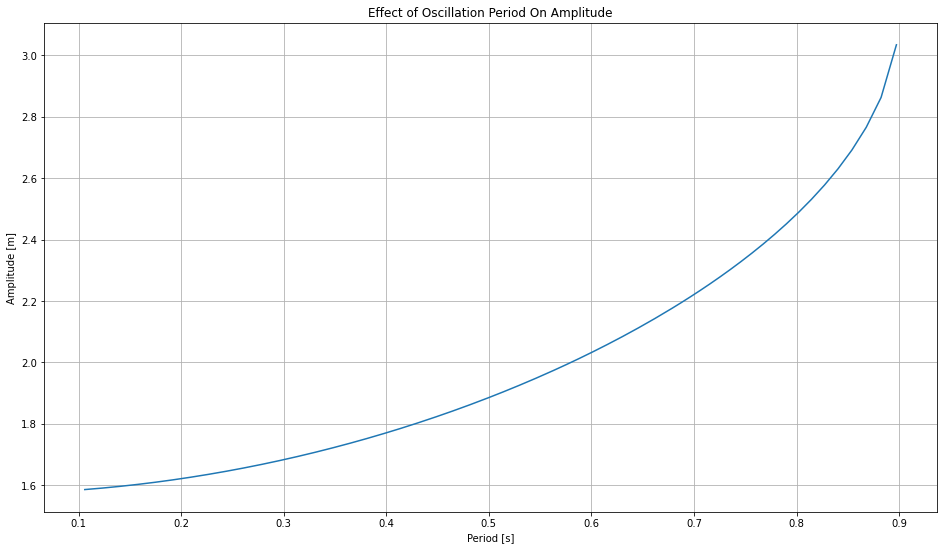

In [20]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes()
ax.plot(w0**(-1),amps)
ax.set_xlabel('Period [s]')
ax.set_ylabel('Amplitude [m]')
ax.set_title('Effect of Oscillation Period On Amplitude')
ax.grid()
plt.show()

## Part B: Period Accuracy

In [21]:
ti = 0
tf = 150
dt = 0.001
t = np.arange(ti, tf, dt)

state0 = np.asarray([np.pi / 2.0, -np.pi/8])

w01 = 0.0885*np.pi
w02 = 0.09*np.pi
w03 = 0.2*np.pi

## Curried differential equation
df_1 = partial(df, w0=w01)
df_2 = partial(df, w0=w02)
df_3 = partial(df, w0=w03)

## Solutions
t, *soln1 = dsolve_simplectic(df_1, t, state0[0], state0[1])
t, *soln2 = dsolve_simplectic(df_2, t, state0[0], state0[1])
t, *soln3 = dsolve_simplectic(df_3, t, state0[0], state0[1])

theta_m1 = get_amplitude(soln1[0])
theta_m2 = get_amplitude(soln2[0])
theta_m3 = get_amplitude(soln3[0])

T_exact1 = (4/w01)*ellipk(np.sin(theta_m1/2))
T_exact2 = (4/w02)*ellipk(np.sin(theta_m2/2))
T_exact3 = (4/w03)*ellipk(np.sin(theta_m3/2))

T_approx1 = get_period(t, soln1[0])
T_approx2 = get_period(t, soln2[0])
T_approx3 = get_period(t, soln3[0])

print(f'Exact Period | Approx. Period | % Error ')
print(f'  {T_exact1:0.4f} s   |    {T_approx1:0.4f} s    | {100*(T_approx1-T_exact1)/T_exact1:0.4f}%')
print(f'  {T_exact2:0.4f} s   |    {T_approx2:0.4f} s    | {100*(T_approx2-T_exact2)/T_exact2:0.4f}%')
print(f'  {T_exact3:0.4f} s   |    {T_approx3:0.4f} s    | {100*(T_approx3-T_exact3)/T_exact3:0.4f}%')

Exact Period | Approx. Period | % Error 
  73.5437 s   |    68.5660 s    | -6.7683%
  53.1268 s   |    48.3200 s    | -9.0478%
  14.0068 s   |    12.3960 s    | -11.4999%


## Plotting

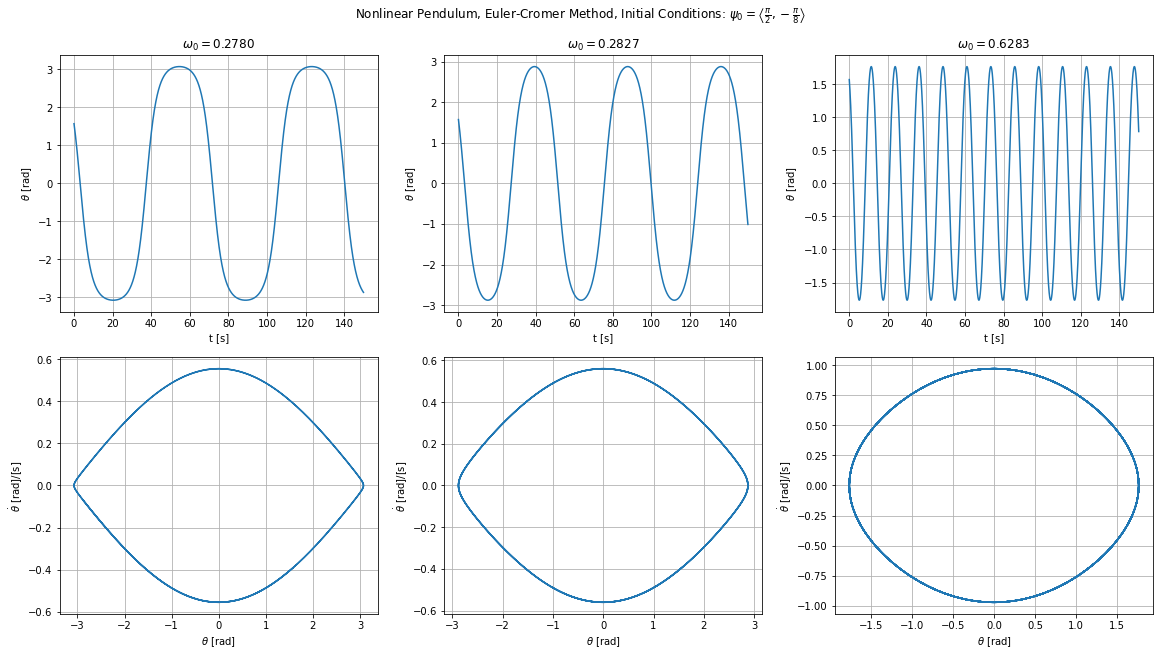

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)
plt.suptitle(r'Nonlinear Pendulum, Euler-Cromer Method, Initial Conditions: $\psi_0=\left<\frac{\pi}{2},-\frac{\pi}{8}\right>$')


ax[0,0].plot(t, soln1[0])
ax[0,0].set_xlabel(r't [s]')
ax[0,0].set_ylabel(r'$\theta$ [rad]')
ax[0,0].set_title(rf'$\omega_0={w01:0.4f}$')
ax[0,0].grid()

ax[0,1].plot(t, soln2[0])
ax[0,1].set_xlabel(r't [s]')
ax[0,1].set_ylabel(r'$\theta$ [rad]')
ax[0,1].set_title(rf'$\omega_0={w02:0.4f}$')
ax[0,1].grid()

ax[0,2].plot(t, soln3[0])
ax[0,2].set_xlabel(r't [s]')
ax[0,2].set_ylabel(r'$\theta$ [rad]')
ax[0,2].set_title(rf'$\omega_0={w03:0.4f}$')
ax[0,2].grid()

ax[1,0].plot(*soln1)
ax[1,0].set_xlabel(r'$\theta$ [rad]')
ax[1,0].set_ylabel(r'$\dot{\theta}$ [rad]/[s]')
ax[1,0].grid()

ax[1,1].plot(*soln2)
ax[1,1].set_xlabel(r'$\theta$ [rad]')
ax[1,1].set_ylabel(r'$\dot{\theta}$ [rad]/[s]')
ax[1,1].grid()

ax[1,2].plot(*soln3)
ax[1,2].set_xlabel(r'$\theta$ [rad]')
ax[1,2].set_ylabel(r'$\dot{\theta}$ [rad]/[s]')
ax[1,2].grid()

plt.show()